### Using shared memory
- While it is possible to use global memory for most operations [Chapter04/conway_gpu_syncthreads.ipynb](Chapter04/conway_gpu_syncthreads.ipynb), we can speed things up by using shared memory
- Shared memory: 
    - Specifically for intercommunication of threads within a single CUDA block; the advantage of using this over global memory is that it is much faster for pure inter-thread communication
    - Memory stored in shared memory cannot directly be accessed by the host
    - shared memory must be copied back into global memory by the kernel itself first.
- _X and _Y macros. (Compiler optimizations notwithstanding, we want to store these values in variables to reduce computation because directly using _X and _Y will recompute the x and y values every time these macros are referenced in our code)

C:\Users\foonwong\AppData\Local\Temp\ipykernel_29800\1148511689.py:13: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  shared_ker = SourceModule("""


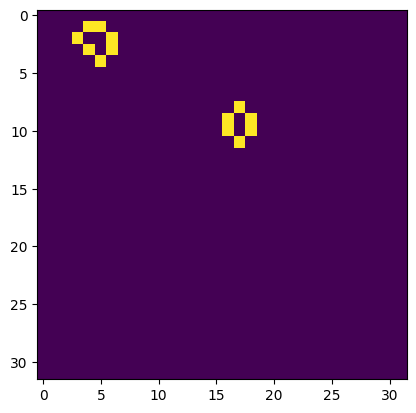

In [1]:
# Iterative Conway's game of life in Python / CUDA C
# this version is meant to illustrate the use of shared kernel memory in CUDA.
# written by Brian Tuomanen for "Hands on GPU Programming with Python and CUDA"

import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt 
from time import time

shared_ker = SourceModule("""    
#define _iters 1000000                       

#define _X  ( threadIdx.x + blockIdx.x * blockDim.x )
#define _Y  ( threadIdx.y + blockIdx.y * blockDim.y )

#define _WIDTH  ( blockDim.x * gridDim.x )
#define _HEIGHT ( blockDim.y * gridDim.y  )

#define _XM(x)  ( (x + _WIDTH) % _WIDTH )
#define _YM(y)  ( (y + _HEIGHT) % _HEIGHT )

#define _INDEX(x,y)  ( _XM(x)  + _YM(y) * _WIDTH )

// return the number of living neighbors for a given cell                
__device__ int nbrs(int x, int y, int * in)
{
     return ( in[ _INDEX(x -1, y+1) ] + in[ _INDEX(x-1, y) ] + in[ _INDEX(x-1, y-1) ] \
                   + in[ _INDEX(x, y+1)] + in[_INDEX(x, y - 1)] \
                   + in[ _INDEX(x+1, y+1) ] + in[ _INDEX(x+1, y) ] + in[ _INDEX(x+1, y-1) ] );
}

__global__ void conway_ker_shared(int * p_lattice, int iters)
{
   // x, y are the appropriate values for the cell covered by this thread
   int x = _X, y = _Y;
   __shared__ int lattice[32*32];
   
   
   lattice[_INDEX(x,y)] = p_lattice[_INDEX(x,y)];
   __syncthreads();

   for (int i = 0; i < iters; i++)
   {
   
       // count the number of neighbors around the current cell
       int n = nbrs(x, y, lattice);
       
       int cell_value;
                       
        
        // if the current cell is alive, then determine if it lives or dies for the next generation.
        if ( lattice[_INDEX(x,y)] == 1)
           switch(n)
           {
              // if the cell is alive: it remains alive only if it has 2 or 3 neighbors.
              case 2:
              case 3: cell_value = 1;
                      break;
              default: cell_value = 0;                   
           }
        else if( lattice[_INDEX(x,y)] == 0 )
             switch(n)
             {
                // a dead cell comes to life only if it has 3 neighbors that are alive.
                case 3: cell_value = 1;
                        break;
                default: cell_value = 0;         
             }
             
        __syncthreads();
        lattice[_INDEX(x,y)] = cell_value;
        __syncthreads();
         
    }
             
    __syncthreads();
    p_lattice[_INDEX(x,y)] = lattice[_INDEX(x,y)];
    __syncthreads();
         
}
""")


conway_ker_shared = shared_ker.get_function("conway_ker_shared")
    

if __name__ == '__main__':
    # set lattice size
    N = 32
    
    lattice = np.int32( np.random.choice([1,0], N*N, p=[0.25, 0.75]).reshape(N, N) )
    lattice_gpu = gpuarray.to_gpu(lattice)    
    
    conway_ker_shared(lattice_gpu, np.int32(1000000), grid=(1,1,1), block=(32,32,1))    
    
    fig = plt.figure(1)
    plt.imshow(lattice_gpu.get())
    plt.show()